## Flux comparions
This notebook compares the predictions of the R. opacus PD630 GSM with the fluxes from 13C-metabolic flux analysis (13C-MFA)

For each reaction in the metabolic flux analysis, the corresponding genome scale flux is found using mapping syntax similar to GPR when 'or' relations are for recations that happen in parallel, and 'and' relations are for reactions that happen sequentially.

### Methods
For each carbon source
<ol>
    <li>Run FBA to get genome scale fluxes</li>
    <li>Split 'or' relations that can be summed together</li>
    <li>For each 'and' relation find the minimum of the reactions and add that to the reaction flux</li>
    <li>Append the summed flux value to the FBA_flux list</li>
</ol>

### Imports

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
import cobra
import pandas as pd
import numpy as np
from edd_utils import login, export_study, export_metadata

### Load model 

In [10]:
model = cobra.io.read_sbml_model("../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml")
model

Name,ropacus_annotated_curated
Memory address,0x07f645bbdf590
Number of metabolites,1583
Number of reactions,2385
Number of groups,0
Objective expression,1.0*Growth - 1.0*Growth_reverse_699ae
Compartments,"cytosol, periplasm, extracellular space"


In [11]:
model.medium

{'EX_glc__D_e': 10.0,
 'EX_h2o_e': 10.0,
 'EX_h_e': 10.0,
 'EX_cl_e': 10.0,
 'EX_pi_e': 10.0,
 'EX_nh4_e': 10.0,
 'EX_fe3_e': 10.0,
 'EX_k_e': 10.0,
 'EX_ca2_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_mn2_e': 10.0,
 'EX_cobalt2_e': 10.0,
 'EX_zn2_e': 10.0,
 'EX_cu2_e': 10.0,
 'EX_o2_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_mobd_e': 10.0,
 'EX_so4_e': 10.0,
 'EX_phenol_e': 1000.0}

In [3]:
# edd_study_slug = 'input-test-study'
# edd_server = 'public-edd.agilebiofoundry.org'
# user= 'garrettroell'
# session = login(edd_server=edd_server, user=user)
# # df = utils.load_study(edd_study_slug=edd_study_slug,edd_server=edd_server,
# #   default_to_system_user=False)

In [4]:
# df = export_study(session, edd_study_slug, edd_server=edd_server)
# df

### Get 13C MFA measured fluxes for glucose

In [5]:
glucose_fluxes = pd.read_csv('../13C_flux_data/13C_glucose_flux_data.csv')
glucose_fluxes.dropna(inplace=True)
print(f'There are {len(glucose_fluxes)} fluxes that can be compared between the MFA and FBA')
glucose_fluxes

There are 37 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Glucose Uptake,GLCpts,Gluc.ext + ATP -> G6P,100.00,100.00,100.00
1,Glycolysis,PGI,G6P <-> F6P,-1.61,-2.09,1.42
2,Glycolysis,F6PA and DHAK,F6P + ATP -> FBP,0.00,0.00,1.91
3,Glycolysis,F6PA and DHAK,FBP <-> DHAP + GAP,0.00,0.00,1.91
4,Glycolysis,TPI,DHAP <-> GAP,0.00,0.00,1.91
5,Glycolysis,GAPD and reverse_PGK,GAP <-> 3PG + ATP + NADH,86.56,82.61,88.84
6,Glycolysis,( reverse_PGM or PGM_1 ) and ENO,3PG <-> PEP,78.52,71.65,81.26
7,Glycolysis,FRUpts2pp or reverse_PPS or SBTpts or MNLpts o...,PEP <-> Pyr + ATP,19.02,-10.89,75.15
8,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,100.00,96.96,100.00
9,Pentose Phosphate Pathway,GND,6PG <-> Ru5P + CO2 + NADPH,6.62,2.07,10.92


### Run glucose flux FBA

In [31]:
with model:
    model.objective = 'Growth_Glucose'
    medium = model.medium
    
    # This is to prevent medium components other than glucose from being growth limitations
    medium = {key:1000 for (key,value) in model.medium.items()}
    
    medium["EX_glc__D_e"] = 100.0
    medium["EX_phenol_e"] = 0.0
    
    model.medium = medium
#     print(model.medium)
    solution = model.optimize()
    
print(solution)

<Solution 11.824 at 0x7f6456761a10>


Define a function to get fluxes and adjust for if flux value should have sign change

In [13]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]

In [33]:
for r in model.metabolites.get_by_id('glc__D_p').reactions:
    print(solution.fluxes[r.id], r)

0.0 LACZpp: h2o_p + lcts_p --> gal_p + glc__D_p
0.0 GLCt2pp: glc__D_p + h_p --> glc__D_c + h_c
0.0 GLCabcpp: atp_c + glc__D_p + h2o_c --> adp_c + glc__D_c + h_c + pi_c
100.0 GLCptspp: glc__D_p + pep_c --> g6p_c + pyr_c
100.0 GLCtex: glc__D_e <=> glc__D_p
0.0 GLCDpp: glc__D_p + h2o_p + q8_c --> glcn_p + h_p + q8h2_c


### Add Glucose FBA flux values to test_df 

In [14]:
FBA_fluxes = []
for _, row in glucose_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value += min([get_flux_value(v, solution) for v in and_split])
    FBA_fluxes.append(flux_value)
    
glucose_fluxes['FBA Value'] = FBA_fluxes
glucose_fluxes

,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,FBA Value
0,Glucose Uptake,GLCpts,Gluc.ext + ATP -> G6P,100.00,100.00,100.00,0.000000
1,Glycolysis,PGI,G6P <-> F6P,-1.61,-2.09,1.42,96.747763
2,Glycolysis,F6PA and DHAK,F6P + ATP -> FBP,0.00,0.00,1.91,0.000000
3,Glycolysis,F6PA and DHAK,FBP <-> DHAP + GAP,0.00,0.00,1.91,0.000000
4,Glycolysis,TPI,DHAP <-> GAP,0.00,0.00,1.91,73.558865
5,Glycolysis,GAPD and reverse_PGK,GAP <-> 3PG + ATP + NADH,86.56,82.61,88.84,152.464356
6,Glycolysis,( reverse_PGM or PGM_1 ) and ENO,3PG <-> PEP,78.52,71.65,81.26,138.989792
7,Glycolysis,FRUpts2pp or reverse_PPS or SBTpts or MNLpts o...,PEP <-> Pyr + ATP,19.02,-10.89,75.15,131.866120
8,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,100.00,96.96,100.00,0.000000
9,Pentose Phosphate Pathway,GND,6PG <-> Ru5P + CO2 + NADPH,6.62,2.07,10.92,0.000000


### Plot FBA vs 13C MFA

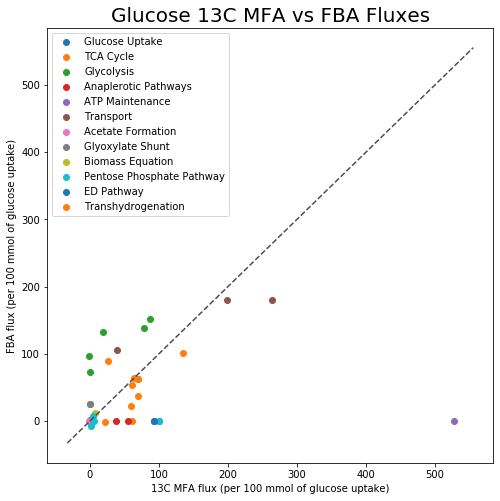

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(glucose_fluxes['Pathway'])):
    pathway_df = glucose_fluxes[glucose_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['FBA Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Glucose 13C MFA vs FBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of glucose uptake)')
plt.ylabel(r'FBA flux (per 100 mmol of glucose uptake)')
plt.legend()
plt.show()

### Get 13C MFA measured fluxes

In [ ]:
glucose_flux_path = "../13C_flux_data/13C_glucose_flux_data.csv"
measured_glucose_df = pd.read_csv(glucose_flux_path)
measured_glucose_df

Eliminate all rows that do not have a defined reactionID

In [ ]:
measured_glucose_df = measured_glucose_df[~pd.isnull(measured_glucose_df['Reaction ID'])]
measured_glucose_df

In [ ]:
measured_flux_dict = {}
measured_reaction_ids = list(measured_glucose_df['Reaction ID'])
for reaction_id in measured_reaction_ids:
#     print(measured_glucose_df[measured_glucose_df['Reaction ID'] == reaction_id]['Reversed?'].values[0])
    measured_flux = measured_glucose_df[measured_glucose_df['Reaction ID'] == reaction_id]['Flux'].values[0] / 10
#     if measured_glucose_df[measured_glucose_df['Reaction ID'] == reaction_id]['Reversed?'].values[0]:
#         measured_flux = -1 * measured_flux
    measured_flux_dict[reaction_id] = measured_flux
measured_flux_dict

### Get FBA simulated fluxes

In [ ]:
simulated_flux_dict = {}
measured_reaction_ids = list(measured_glucose_df['Reaction ID'])
for reaction_id in measured_reaction_ids:
    simulated_flux_dict[reaction_id] = solution.fluxes[reaction_id]

simulated_flux_dict

### Plot FBA vs measured fluxes

In [ ]:
measured_flux_list = list(measured_flux_dict.values())
simulated_flux_list = list(simulated_flux_dict.values())
labels = list(measured_flux_dict.keys())

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(measured_flux_list, simulated_flux_list)
# ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")
for i in range(len(labels)):
    xy = (measured_flux_list[i]+.1,simulated_flux_list[i]+.1)
    ax.annotate(labels[i],xy)
plt.title(r'R. opacus 13C MFA vs FBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux measurement (mmol/gDW/h)')
plt.ylabel(r'FBA flux prediction (mmol/gDW/h)')
plt.show()

### Simulate with pfba

In [ ]:
pfba_solution = cobra.flux_analysis.pfba(model)
len(pfba_solution.fluxes)

In [ ]:
pfba_flux_dict = {}
measured_reaction_ids = list(measured_glucose_df['Reaction ID'])
for reaction_id in measured_reaction_ids:
    pfba_flux_dict[reaction_id] = pfba_solution.fluxes[reaction_id]

pfba_flux_dict

In [ ]:
measured_flux_list = list(measured_flux_dict.values())
simulated_flux_list = list(pfba_flux_dict.values())
labels = list(measured_flux_dict.keys())

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(measured_flux_list, simulated_flux_list)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")
for i in range(len(labels)):
    xy = (measured_flux_list[i]+.1,simulated_flux_list[i]+.1)
    ax.annotate(labels[i],xy)
plt.title(r'R. opacus 13C MFA vs FBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux measurement (mmol/gDW/h)')
plt.ylabel(r'pFBA flux prediction (mmol/gDW/h)')
plt.show()

### Simulate with geometric FBA

In [ ]:
# geometric_fba_sol = cobra.flux_analysis.geometric_fba(model)
# len(geometric_fba_sol.fluxes)

In [ ]:
for r in model.metabolites.get_by_id('mal__L_c').reactions:
    print(r.name, r)